<a href="https://colab.research.google.com/github/yeonghun00/stock_public/blob/main/News_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install konlpy

In [31]:
list(range(1,2))

[1]

In [40]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
import html

class News:
  def __init__(self):
    self.headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}

  def get_ranking(self, page=1, date='1'):
    date = str(datetime.datetime.now().date().strftime("%Y%m%d")) if date == '1' else date
    pages = list(range(1,page+1))
    li = []
    for page in pages:
      url = 'https://finance.naver.com/news/news_list.nhn?mode=RANK&date=' + date + '&page=' + str(page)
      result = requests.get(url, headers = self.headers)
      bs_obj = BeautifulSoup(result.content, "html.parser")

      div = bs_obj.find_all('div', {'class':'hotNewsList'})
      li+=[html.unescape(x['href']) for x in div[0].find_all('a')]
    return li

  def get_main(self, date='1'):
    date = str(datetime.datetime.now().date().strftime("%Y-%m-%d")) if date == '1' else date
    url = 'https://finance.naver.com/news/mainnews.nhn'
    result = requests.get(url, headers = self.headers)
    bs_obj = BeautifulSoup(result.content, "html.parser")
    return [x.find_all('a')[0]['href'] for x in bs_obj.find_all('dd', {'class':'articleSubject'})]
    
  def get_breaking(self):
    pass

  # 시황 전망: 401
  # 기업 종목분석: 402
  # 해외 증시: 403
  # 채권 선물: 404
  # 공시 메모: 406
  # 환율: 429
  def get_focus(self, page=1, code=403, date='1', ):
    date = str(datetime.datetime.now().date().strftime("%Y%m%d")) if date == '1' else date
    pages = range(0,page)
    li = []
    for page in pages:
      url = 'https://finance.naver.com/news/news_list.nhn?mode=LSS3D&section_id=101&section_id2=258&section_id3='\
      + str(code) +  '&date=' + str(date) + '&page=' + str(page)
      result = requests.get(url, headers = self.headers)
      bs_obj = BeautifulSoup(result.content, "html.parser")
      temp = [html.unescape(x.find_all('a')[0]['href']) for x in bs_obj.find_all('dd', {'class':'articleSubject'})]
      # 업데이트 가능
      li+=[x.replace('§', '&sect') for x in temp]
    return li

  def get_article(self, url):
    url = 'https://finance.naver.com/' + url
    result = requests.get(url, headers = self.headers)
    bs_obj = BeautifulSoup(result.content, "html.parser")

    title = ' '.join(bs_obj.find_all('div', {'class': 'article_info'})[0].find_all('h3')[0].get_text().split())
    context = bs_obj.find_all('div', {'class': 'articleCont'})[0]
    try:
      subheading = context.find_all('strong')[0].get_text()
    except:
      subheading = ''
    t = ' '.join(context.get_text().split())
    text = t[:t.find('@')]
    text = text.replace(subheading, '')
    return title, subheading, text

In [55]:
from multiprocessing import Pool

news = News()
news_list = news.get_ranking(4)
with Pool(30) as p:
    li = p.map(news.get_article, news_list)
li = np.array(li)

dic = {'Title':li[:,0], 'Subheading':li[:,1], 'Text':li[:,2]}
df = pd.DataFrame.from_dict(dic)
df

1
2
3
4


In [56]:
df = pd.DataFrame.from_dict(dic)
df

,Title,Subheading,Text
0,"13배 뛴 AMC… 2차 공매도전쟁, 서학개미들 대거 참전",공매도 몰려 연초 대비 13배 ↑‘게임스톱 사태’ 재현 가능성 우려,지난 1월 공매도와의 전쟁으로 글로벌 증시의 화제가 됐던 ‘게임스톱 사태’가 재현될...
1,피할 수 없을 가격 인상…라면株를 담아야 하는 이유,,"[머니투데이 구단비 기자] 농심, 오뚜기, 삼양식품 등 국내 주요 식품 업체들의 1..."
2,"소외받던 5G 장비株, 해외 발판삼아 주가 반등 노린다",,[머니투데이 김영상 기자] 올해 상승장에서 가장 소외된 업종 중 하나로 꼽힌 5G(...
3,천당 지옥 오가는 스팩…투기세력 돌린 폭탄 개미가 떠안나,전날 14개 스팩 상한가 → 이날은 2개 하한가합병대상 없어도 주가 변동성 높아져…...,[이데일리 권효중 기자] “스팩주 지금이 기회입니다. 놓치지 마세요” “코인세력이 ...
4,확진자 감소에 항공株↑…'공매도전쟁' AMC 22% 폭등[뉴욕마감],,[머니투데이 뉴욕=임동욱 특파원] 6월 첫 거래일 뉴욕증시가 경제 재개에 대한 낙관...
...,...,...,...
95,"이유없이 오르던 스팩株, 줄줄이 급락…""투자자 주의 요구""",,(사진=게티이미지뱅크)최근 특별한 호재 없이 주가가 급등했던 스팩(SPAC·기업인수...
96,"""美달러, 3분기에 3년래 최저치 하향 돌파 전망 이유는""",하이투자증권 보고서,"[이데일리 이광수 기자] 미국 달러화의 약세가 지속되는 가운데, 3년래 최저치를 하..."
97,"[특징주] 오하임아이엔티, 송해연 감사 윤석열 서울대 법대 동문·재건축 활성화 기대...",,[아시아경제 이민우 기자] 온라인가구 유통기업 오하임아이엔티주가가 강세다. 야권 대...
98,"HK이노엔, 순도 80% '뉴틴 식물성 알티지 오메가3 80' 출시",식물성 플랑크톤인 미세조류서 추출중금속 성분 없어,HK이노엔은 '뉴틴 식물성 알티지 오메가3' 신제품을 출시했다고 2일 밝혔다. 새로...


In [4]:
'''news = News()
dic = {'Title':[], 'Subheading':[], 'Text':[]}

for i in news.get_ranking(4):
  title, subheading, text = news.get_article(i)
  dic['Title'].append(title)
  dic['Subheading'].append(subheading)
  dic['Text'].append(text)

df = pd.DataFrame.from_dict(dic)
df'''

,Title,Subheading,Text
0,"13배 뛴 AMC… 2차 공매도전쟁, 서학개미들 대거 참전",공매도 몰려 연초 대비 13배 ↑‘게임스톱 사태’ 재현 가능성 우려,지난 1월 공매도와의 전쟁으로 글로벌 증시의 화제가 됐던 ‘게임스톱 사태’가 재현될...
1,피할 수 없을 가격 인상…라면株를 담아야 하는 이유,,"[머니투데이 구단비 기자] 농심, 오뚜기, 삼양식품 등 국내 주요 식품 업체들의 1..."
2,"소외받던 5G 장비株, 해외 발판삼아 주가 반등 노린다",,[머니투데이 김영상 기자] 올해 상승장에서 가장 소외된 업종 중 하나로 꼽힌 5G(...
3,천당 지옥 오가는 스팩…투기세력 돌린 폭탄 개미가 떠안나,전날 14개 스팩 상한가 → 이날은 2개 하한가합병대상 없어도 주가 변동성 높아져…...,[이데일리 권효중 기자] “스팩주 지금이 기회입니다. 놓치지 마세요” “코인세력이 ...
4,확진자 감소에 항공株↑…'공매도전쟁' AMC 22% 폭등[뉴욕마감],,[머니투데이 뉴욕=임동욱 특파원] 6월 첫 거래일 뉴욕증시가 경제 재개에 대한 낙관...
...,...,...,...
70,"현대차증권 ""LG화학, 과도한 저평가 상태""…목표가↓",목표주가 140만원→110만원으로 하향 조정,[서울=뉴시스] 김제이 기자 = 현대차증권은 2일 LG화학에 대해 LG에너지솔루션 ...
71,"""빙그레, 2분기 매출 성장세 기대…투자의견 '매수'""-IBK",,IBK투자증권은 2일 빙그레에 대해 2분기 성수기의 매출 성장세가 기대된다며 투자의...
72,[표]일본 주요기업 주가(6/1),,[이데일리 증권시장부]증권시장부 (edaily.co.kr)▶ #24시간 빠른 #미리...
73,"미스터블루, 웹툰·게임 동반 성장 주목-KB증권",▶ 날로먹고 구워먹는 금융이슈 [파인애플]▶ 모(毛)아 모아 [모아시스]▶ 헉! 소...,사진=미스터블루 [파이낸셜뉴스] KB증권은 2일 미스터블루에 대해 웹툰 가입자 및 ...


In [5]:
# korean font
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip'
!unzip "NotoSansCJKkr-hinted.zip"
!mv NotoSansCJKkr-Medium.otf /usr/share/fonts/truetype/

--2021-06-02 01:35:46--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 142.251.33.208, 2607:f8b0:4004:837::2010
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|142.251.33.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121163981 (116M) [application/zip]
Saving to: ‘NotoSansCJKkr-hinted.zip.2’

NotoSansCJKkr-hinte 100%[===================>] 115.55M  86.9MB/s    in 1.3s    

2021-06-02 01:35:47 (86.9 MB/s) - ‘NotoSansCJKkr-hinted.zip.2’ saved [121163981/121163981]

Archive:  NotoSansCJKkr-hinted.zip
replace LICENSE_OFL.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n -a
replace NotoSansCJKkr-Black.otf? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace NotoSansCJKkr-Black.otf? [y]es, [n]o, [A]ll, [N]one, [r]ename: -a n
error:  invalid response [-a n]
replace NotoSansCJKkr-Bl

(-0.5, 1199.5, 799.5, -0.5)

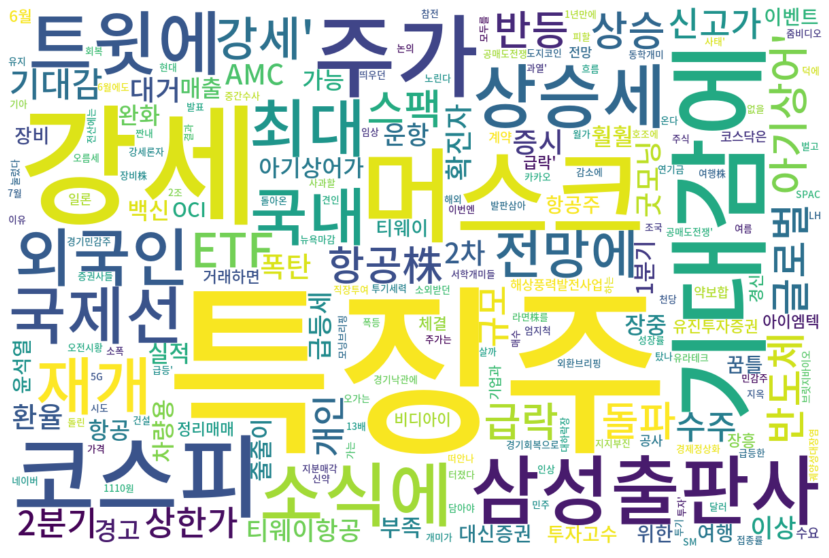

In [63]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(df['Title'].values)
stop_words = ['있다', '기자', '다만', '등의', '것으로']
wordcloud = WordCloud(stopwords = stop_words, \
                      font_path='/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf', \
                      background_color='white', \
                      width=1200, height=800).generate(text)
plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


In [ ]:
# https://wikidocs.net/22530
# 불용어 제거 

from konlpy.tag import Hannanum

class Analyser:
  def __init__(self, news_df):
    self.news_df = news_df

  def get_tokenized_df(self):
    hannanum = Hannanum()
    return self.news_df.applymap(hannanum.pos)
     

In [ ]:
analyser = Analyser(df)

In [ ]:
hannanum = Hannanum()

def keyword_extractor(tagger, text):
    tokens = hannanum.morphs(text)
    tokens = [ token for token in tokens if len(token) > 1 ] # 한 글자인 단어는 제외
    count_dict = [(token, text.count(token)) for token in tokens ]
    ranked_words = sorted(count_dict, key=lambda x:x[1], reverse=True)[:10]
    return [ keyword for keyword, freq in ranked_words ]

In [ ]:
print(keyword_extractor(hannanum, df['Text'][0]))

In [ ]:
from konlpy.tag import Twitter

hannanum = Hannanum()
for i in range(0,len(df['Text'])):
  print(keyword_extractor(hannanum, df['Text'][i]))

In [ ]:
'''!pip install newspaper3k
from newspaper import Article
url = 'https://finance.naver.com/news/news_read.nhn?article_id=0004944778&office_id=018&mode=mainnews&type=&date=2021-06-01&page=1'
a = Article(url, language='ko')
a.download()
a.parse()
print(a.title)
print(a.text)'''

In [ ]:
s= 